# 1. Seleção

- **Equipe**: Eduardo Kohei Seko, Marcos Vinícius Brito de Araújo, Vitor Cardoso de Moraes

Nesta primeira etapa, definimos a base do nosso projeto.

1. Extraímos o [Adult Data Set (Censo)](https://archive.ics.uci.edu/dataset/2/adult) do repositório da UCI.

2. Separamos os dados estruturais (as features, como idade, educação e horas de trabalho) da nossa variável-alvo (target), que é prever se a renda da pessoa ultrapassa os 50 mil dólares anuais.

In [37]:
from ucimlrepo import fetch_ucirepo
import pandas as pd

In [38]:
adult = fetch_ucirepo(id=2)

In [39]:
df = adult.data.features
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba


In [40]:
target = adult.data.targets
target.head()

,income
0,<=50K
1,<=50K
2,<=50K
3,<=50K
4,<=50K


In [41]:
df["income"] = target

# 2. Pré-Processamento

Investigamos a qualidade dos dados e lidamos com valores ausentes (como os campos em branco ou preenchidos com "?").

1. Comparamos empiricamente várias estratégias de limpeza para ver qual ajudava mais o modelo.

2. Descobrimos que não remover linhas com dados faltantes era a melhor opção. Ao apagar dados com "?" ou nulos, nossa acurácia caiu para 86,56%. A escolha final foi tratar esses dados ausentes preenchendo-os com a moda (valor mais frequente) e removendo as colunas `education-num`, `fnlwgt` devido, a *feature* `education-num` ser apenas um identificador de `education`, e aplicando a transformação `logmod` na coluna `fnlwgt`.

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Metodos</th>
      <th>acurácia</th>
      <th>Modelo</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td> Sem alterações no preprocessamento </td>
      <td> 87,69% </td>
      <td rowspan="9" style="vertical-align: middle;">XGBoost</td>
    </tr>
    <tr>
      <td>Removendo linhas com valores nulos</td>
      <td> 87,49% </td>
    </tr>
    <tr>
      <td>Substituindo valores nulos pela moda</td>
      <td> 87,78% </td>
    </tr>
    <tr>
      <td>Substituir nulos pela moda e dropar duplicados</td>
      <td> 87,54% </td>
    </tr>
    <tr>
      <td>Remover linhas com nulos e duplicados</td>
      <td>87,19%</td>
    </tr>
    <tr>
      <td>Remover linhas com valores "?"</td>
      <td>86,56%</td>
    </tr>
    <tr>
      <td>Substituir valores "?" pela moda</td>
      <td>87,59%</td>
    </tr>
    <tr>
      <td>Substituir pela moda valores nulos e "?"</td>
      <td>87,63%</td>
    </tr>
    <tr style="font-weight: bold;">
      <td>Valores nulos pela moda e drop de 2 colunas (education-num, fnlwgt) e ajuste na distribuição de fnlwgt</td>
      <td>87,94%</td>
    </tr>
  </tbody>
</table>
</div>

In [42]:
print(f"Shape inicial: {df.shape}")
df.head()

Shape inicial: (48842, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


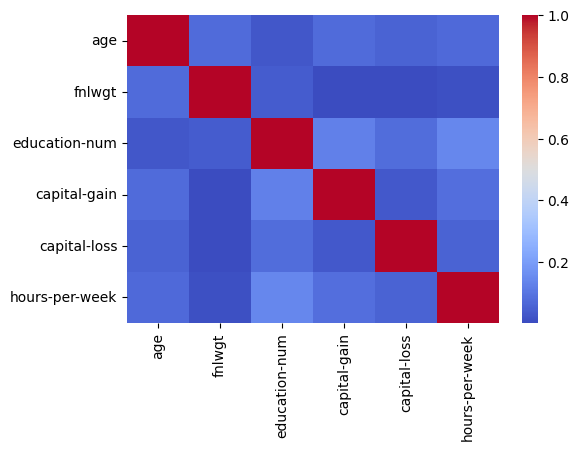

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = df.select_dtypes(include=['number']).corr().abs()

plt.figure(figsize=(6,4))
sns.heatmap(corr, cmap='coolwarm')
plt.show()

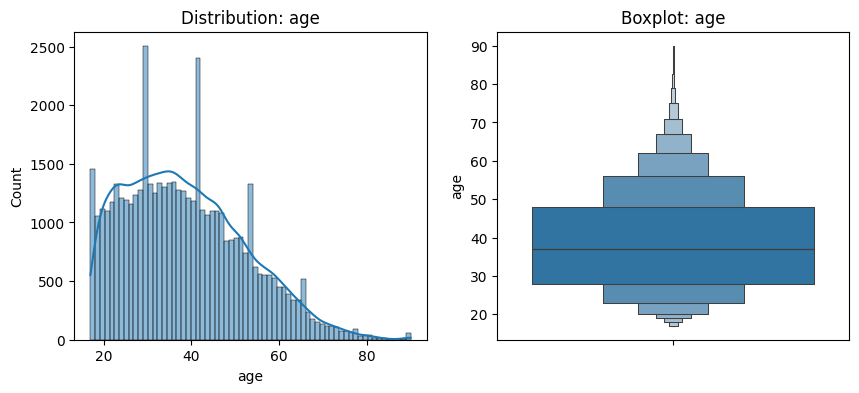

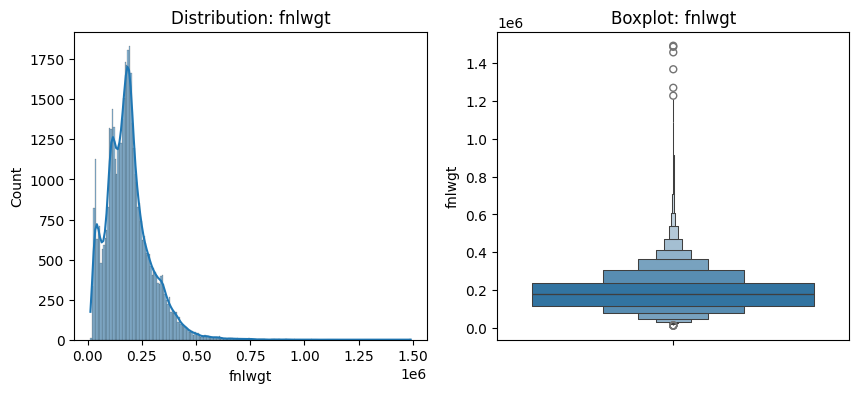

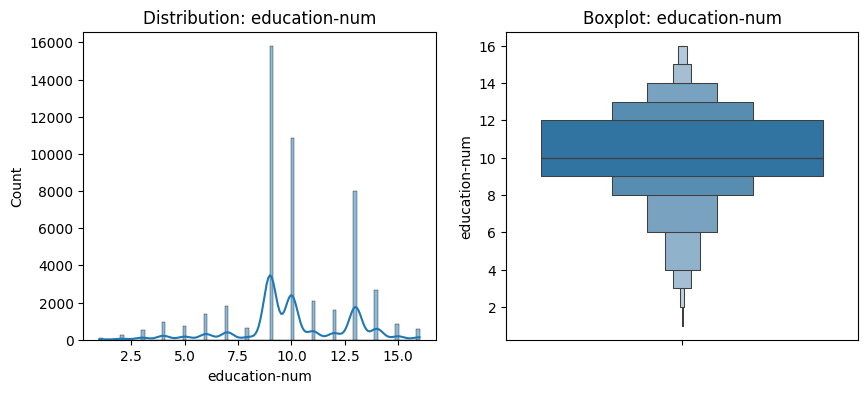

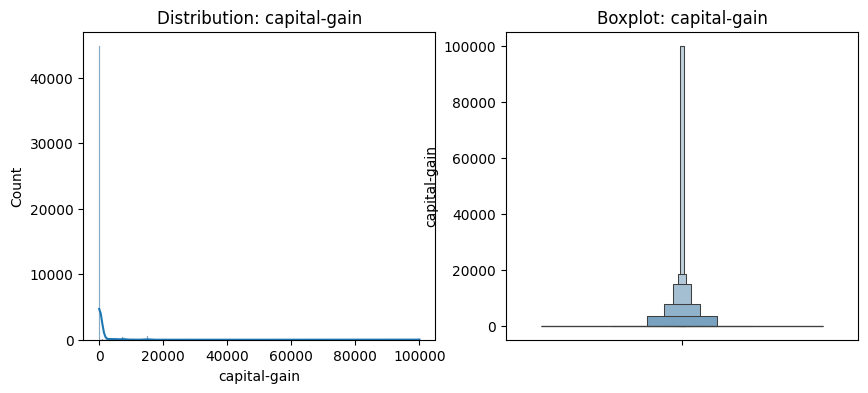

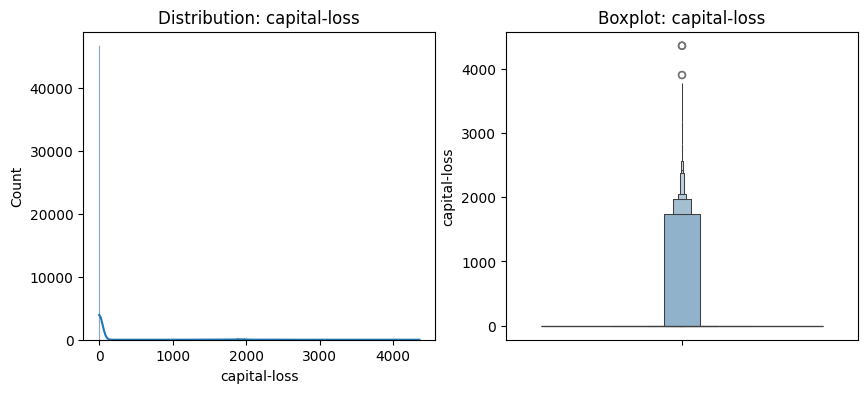

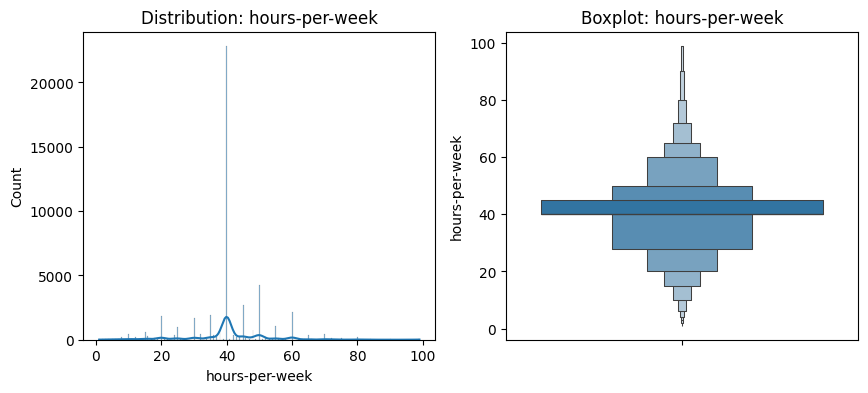

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = df.select_dtypes(include=['int', 'float'])

for col in num_cols:
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution: {col}')

    plt.subplot(1,2,2)
    sns.boxenplot(df[col])
    plt.title(f'Boxplot: {col}')

    plt.show()

In [46]:
import numpy as np

df['fnlwgt_logmod'] = np.sign(df['fnlwgt']) * np.log1p(np.abs(df['fnlwgt']))

In [47]:
print("Valores ausentes por coluna:")
print(df.isna().sum())
print(f"\nTotal de linhas com valores ausentes: {df.isna().any(axis=1).sum()}")

Valores ausentes por coluna:
age                 0
workclass         963
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
income              0
fnlwgt_logmod       0
dtype: int64

Total de linhas com valores ausentes: 1221


In [48]:
df[df.isna().any(axis=1)]

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,fnlwgt_logmod
32565,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.,11.547308
32567,29,NaN,227026,HS-grad,9,Never-married,NaN,Unmarried,Black,Male,0,0,40,United-States,<=50K.,12.332824
32574,58,NaN,299831,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,35,United-States,<=50K.,12.610978
32580,40,Private,85019,Doctorate,16,Married-civ-spouse,Prof-specialty,Husband,Asian-Pac-Islander,Male,0,0,45,NaN,>50K.,11.350642
32583,72,NaN,132015,7th-8th,4,Divorced,NaN,Not-in-family,White,Female,0,0,6,United-States,<=50K.,11.790678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48769,21,NaN,212661,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.,12.267459
48800,73,NaN,144872,HS-grad,9,Married-civ-spouse,NaN,Husband,White,Male,0,0,25,Canada,<=50K.,11.883613
48812,81,NaN,26711,Assoc-voc,11,Married-civ-spouse,NaN,Husband,White,Male,2936,0,20,United-States,<=50K.,10.192868
48826,50,Local-gov,139347,Masters,14,Married-civ-spouse,Prof-specialty,Wife,White,Female,0,0,40,NaN,>50K.,11.844730


In [49]:

nan_columns = df.columns[df.isna().any()].tolist()
print(f"Colunas com valores ausentes: {nan_columns}")
for column in nan_columns:
    print(f"Preenchendo valores ausentes na coluna '{column}' com a moda.")
    df[column] = df[column].fillna(df[column].mode()[0])
print("\nVerificação:")
print(df.isna().sum())

Colunas com valores ausentes: ['workclass', 'occupation', 'native-country']
Preenchendo valores ausentes na coluna 'workclass' com a moda.
Preenchendo valores ausentes na coluna 'occupation' com a moda.
Preenchendo valores ausentes na coluna 'native-country' com a moda.

Verificação:
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
fnlwgt_logmod     0
dtype: int64


In [50]:
for col in df.columns:
    n_unique = df[col].nunique()
    print(f"{col} ({n_unique} valores únicos):")
    print(df[col].unique())
    print()

age (74 valores únicos):
[39 50 38 53 28 37 49 52 31 42 30 23 32 40 34 25 43 54 35 59 56 19 20 45
 22 48 21 24 57 44 41 29 18 47 46 36 79 27 67 33 76 17 55 61 70 64 71 68
 66 51 58 26 60 90 75 65 77 62 63 80 72 74 69 73 81 78 88 82 83 84 85 86
 87 89]

workclass (9 valores únicos):
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov' '?'
 'Self-emp-inc' 'Without-pay' 'Never-worked']

fnlwgt (28523 valores únicos):
[ 77516  83311 215646 ... 173449  89686 350977]

education (16 valores únicos):
['Bachelors' 'HS-grad' '11th' 'Masters' '9th' 'Some-college' 'Assoc-acdm'
 'Assoc-voc' '7th-8th' 'Doctorate' 'Prof-school' '5th-6th' '10th'
 '1st-4th' 'Preschool' '12th']

education-num (16 valores únicos):
[13  9  7 14  5 10 12 11  4 16 15  3  6  2  1  8]

marital-status (7 valores únicos):
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']

occupation (15 valores únicos):
['Adm-clerical' 'Exec-managerial' 'Handlers-

In [51]:
print("Valores originais de 'income':")
print(df["income"].unique())

df["income"] = df["income"].str.replace(".", "").str.strip()

print("\nValores após limpeza:")
print(df["income"].unique())

Valores originais de 'income':
['<=50K' '>50K' '<=50K.' '>50K.']

Valores após limpeza:
['<=50K' '>50K']


In [52]:
print("Distribuição de 'occupation':")
print(df["occupation"].value_counts())
print(f"\nRegistros com '?': {(df['occupation'] == '?').sum()}")

Distribuição de 'occupation':
occupation
Prof-specialty       7138
Craft-repair         6112
Exec-managerial      6086
Adm-clerical         5611
Sales                5504
Other-service        4923
Machine-op-inspct    3022
Transport-moving     2355
Handlers-cleaners    2072
?                    1843
Farming-fishing      1490
Tech-support         1446
Protective-serv       983
Priv-house-serv       242
Armed-Forces           15
Name: count, dtype: int64

Registros com '?': 1843


In [53]:
print("Distribuição de 'native-country':")
print(df["native-country"].value_counts())
print(f"\nRegistros com '?': {(df['native-country'] == '?').sum()}")

Distribuição de 'native-country':
native-country
United-States                 44106
Mexico                          951
?                               583
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua      

In [54]:
print("Colunas antes da remoção:")
print(df.columns.tolist())

df = df.drop(columns=["education-num", "fnlwgt"])

print("\nColunas após remoção:")
print(df.columns.tolist())
print(f"\nShape final: {df.shape}")

Colunas antes da remoção:
['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income', 'fnlwgt_logmod']

Colunas após remoção:
['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income', 'fnlwgt_logmod']

Shape final: (48842, 14)


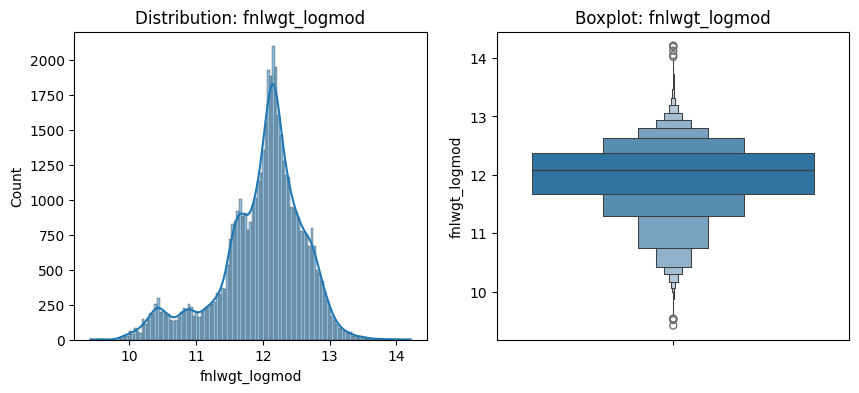

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

num_cols = ['fnlwgt_logmod']

for col in num_cols:
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution: {col}')

    plt.subplot(1,2,2)
    sns.boxenplot(df[col])
    plt.title(f'Boxplot: {col}')

    plt.show()

# 3. Transformação

Modelos matemáticos não leem textos e são sensíveis a escalas numéricas diferentes. Nesta fase, traduzimos os dados para o modelo.

+ Transformamos variáveis categóricas (como "Private" e "Local-gov") em números através do **One-Hot Encoding** e ajustamos escalas numéricas.

+ Testamos tanto a **padronização** quanto a **normalização** dos dados. Como ambas empataram em 87,94% de acurácia, comprovamos que o modelo escolhido (baseado em árvores) é robusto e invariante à escala.

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Metodos</th>
      <th>acurácia</th>
      <th>Modelo</th>
    </tr>
  </thead>
  <tbody>
  <tr>
      <td><b>Sem métodos de scaler</b></td>
      <td><b>87,94%</b></td>
      <td rowspan="3" style="vertical-align: middle;">XGBoost</td>
    </tr>
    <tr>
      <td><b>Padronizando os dados</b></td>
      <td><b>87,94%</b></td>
    </tr>
    <tr>
      <td><b>Normalizando os dados</b></td>
      <td><b>87,94%</b></td>
    </tr>
  </tbody>
</table>
</div>

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [57]:
print(f"Shape do dataset: {df.shape}")
df.head()

Shape do dataset: (48842, 14)


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,fnlwgt_logmod
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,11.258253
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,11.330348
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,12.281398
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K,12.366157
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K,12.732013


In [58]:
y = (df["income"] == ">50K").astype(int)
X = df.drop(columns=["income"])

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print("\nDistribuição da variável target:")
print(y.value_counts())
print("\nProporção:")
print(y.value_counts(normalize=True))

Shape de X: (48842, 13)
Shape de y: (48842,)

Distribuição da variável target:
income
0    37155
1    11687
Name: count, dtype: int64

Proporção:
income
0    0.760718
1    0.239282
Name: proportion, dtype: float64


In [59]:
numerical_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

print(f"Variáveis numéricas ({len(numerical_cols)}):")
print(numerical_cols)
print(f"\nVariáveis categóricas ({len(categorical_cols)}):")
print(categorical_cols)

Variáveis numéricas (5):
['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'fnlwgt_logmod']

Variáveis categóricas (8):
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']


In [60]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y,
)

print(f"Shape de X_train: {X_train.shape}")
print(f"Shape de X_test: {X_test.shape}")
print(f"Shape de y_train: {y_train.shape}")
print(f"Shape de y_test: {y_test.shape}")

print("\nDistribuição em treino:")
print(y_train.value_counts(normalize=True))
print("\nDistribuição em teste:")
print(y_test.value_counts(normalize=True))

Shape de X_train: (39073, 13)
Shape de X_test: (9769, 13)
Shape de y_train: (39073,)
Shape de y_test: (9769,)

Distribuição em treino:
income
0    0.76073
1    0.23927
Name: proportion, dtype: float64

Distribuição em teste:
income
0    0.760672
1    0.239328
Name: proportion, dtype: float64


In [61]:
X_train_encoded = pd.get_dummies(X_train, columns=categorical_cols, drop_first=False)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_cols, drop_first=False)

print("\nShape após encoding:")
print(f"X_train_encoded: {X_train_encoded.shape}")
print(f"X_test_encoded: {X_test_encoded.shape}")


Shape após encoding:
X_train_encoded: (39073, 107)
X_test_encoded: (9769, 106)


In [62]:
X_train_encoded, X_test_encoded = X_train_encoded.align(
    X_test_encoded,
    join="left",
    axis=1,
    fill_value=0,
)

print("\nShape após alinhamento:")
print(f"X_train_encoded: {X_train_encoded.shape}")
print(f"X_test_encoded: {X_test_encoded.shape}")
print(f"\nColunas idênticas: {X_train_encoded.columns.equals(X_test_encoded.columns)}")


Shape após alinhamento:
X_train_encoded: (39073, 107)
X_test_encoded: (9769, 107)

Colunas idênticas: True


In [63]:
print("Colunas numéricas a serem normalizadas:")
print(numerical_cols)

existing_num_cols = [col for col in numerical_cols if col in X_train_encoded.columns]
print("\nColunas numéricas presentes:")
print(existing_num_cols)

Colunas numéricas a serem normalizadas:
['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'fnlwgt_logmod']

Colunas numéricas presentes:
['age', 'capital-gain', 'capital-loss', 'hours-per-week', 'fnlwgt_logmod']


In [64]:
standard = False
scaler = StandardScaler() if standard else MinMaxScaler()

X_train_encoded[existing_num_cols] = scaler.fit_transform(X_train_encoded[existing_num_cols])
X_test_encoded[existing_num_cols] = scaler.transform(X_test_encoded[existing_num_cols])

print("\nEstatísticas das variáveis numéricas no treino:")
print(X_train_encoded[existing_num_cols].describe())


Estatísticas das variáveis numéricas no treino:
                age  capital-gain  capital-loss  hours-per-week  fnlwgt_logmod
count  39073.000000  39073.000000  39073.000000    39073.000000   39073.000000
mean       0.296486      0.010381      0.019928        0.402825       0.524065
std        0.187474      0.072050      0.092120        0.126543       0.134578
min        0.000000      0.000000      0.000000        0.000000       0.000000
25%        0.150685      0.000000      0.000000        0.397959       0.458173
50%        0.273973      0.000000      0.000000        0.397959       0.547092
75%        0.424658      0.000000      0.000000        0.448980       0.608663
max        1.000000      1.000000      1.000000        1.000000       1.000000


# 4. Data Mining

Esta é a fase de aprendizado, onde aplicamos o algoritmo principal para extrair os padrões da base de dados.

- Definimos o **XGBoost** como nosso modelo principal devido à sua alta performance com dados tabulares.

+ Para tentar melhorar o modelo, aplicamos técnicas de busca de hiperparâmetros (como o **Grid Search** e **Random Search**). Curiosamente, observamos que os parâmetros padrão do XGBoost já eram extremamente otimizados para essa base (87,94%), tendo um desempenho até levemente superior à busca exaustiva que fizemos (87,88%), o que nos ensinou sobre o risco de *overfitting* na otimização.

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>Metodos</th>
      <th>acurácia</th>
      <th>Modelo</th>
    </tr>
  </thead>
  <tbody>
  <tr>
      <td><b>Sem métodos de hiperparametros</b></td>
      <td><b>87,94%</b></td>
      <td rowspan="4" style="vertical-align: middle;">XGBoost</td>
    </tr>
    <tr>
      <td>Grid Search</td>
      <td>87,88%</td>
    </tr>
    <tr>
      <td>Random Search</td>
      <td>87,88%</td>
    </tr>
  </tbody>
</table>
</div>

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

In [66]:
models = {
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42)
    },

    "Random Forest": {
        "model": RandomForestClassifier(random_state=42, n_jobs=-1),
    },

    "XGBoost": {
        "model": XGBClassifier(random_state=42, eval_metric="logloss", n_jobs=-1),
    },
}

In [67]:
results = {}

for name, mp in models.items():
    model = mp['model']
    model.fit(X_train_encoded, y_train.values.ravel())
    test_score = model.score(X_test_encoded, y_test)

    results[name] = {
        "model": model,
        "params": model.get_params(),
        "test_score": test_score
    }

In [68]:
comparison = pd.DataFrame({
    "model": list(results.keys()),
    "test_score": [results[m]["test_score"] for m in results],
}).sort_values("test_score", ascending=False)

print(comparison.to_string(index=False))

              model  test_score
            XGBoost    0.879414
      Random Forest    0.855154
Logistic Regression    0.851571


In [69]:
best_model_name = comparison.iloc[0]["model"]
best_model = results[best_model_name]['model']

print(f"Best Model: {best_model_name}")
print(f"Test Accuracy: {results[best_model_name]['test_score']:.4f}")

Best Model: XGBoost
Test Accuracy: 0.8794


# 5. Avaliação

A fase final serviu para comprovar matematicamente que nosso modelo funciona e pode generalizar o conhecimento. Avaliamos todas as modificações anteriores mantendo a métrica de acurácia como foco. Conseguimos provar que, com o tratamento correto de dados categóricos e respeitando a natureza do algoritmo (sem deletar dados cegamente), estabilizamos a capacidade preditiva do modelo em quase 88% de acerto no mundo real.

In [70]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score

In [71]:
y_pred = best_model.predict(X_test_encoded)
print(classification_report(y_test, y_pred, target_names=["<=50K", ">50K"]))
print(f"Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")
print(f"Precision: {precision_score(y_test, y_pred) * 100:.2f}%")

              precision    recall  f1-score   support

       <=50K       0.90      0.95      0.92      7431
        >50K       0.80      0.67      0.73      2338

    accuracy                           0.88      9769
   macro avg       0.85      0.81      0.82      9769
weighted avg       0.88      0.88      0.88      9769

Accuracy: 87.94%
Precision: 79.59%


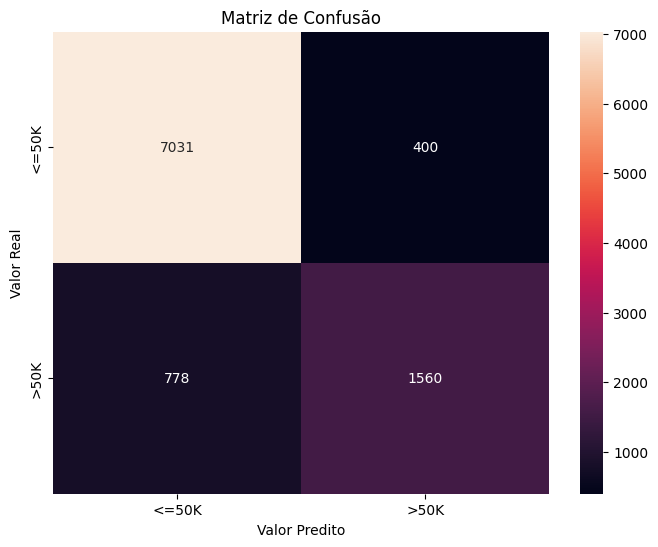

Verdadeiros Negativos (<=50K corretos): 7031
Falsos Positivos (previu >50K, era <=50K): 400
Falsos Negativos (previu <=50K, era >50K): 778
Verdadeiros Positivos (>50K corretos): 1560


In [72]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=["<=50K", ">50K"],
    yticklabels=["<=50K", ">50K"],
)
plt.ylabel("Valor Real")
plt.xlabel("Valor Predito")
plt.title("Matriz de Confusão")
plt.show()

print(f"Verdadeiros Negativos (<=50K corretos): {cm[0,0]}")
print(f"Falsos Positivos (previu >50K, era <=50K): {cm[0,1]}")
print(f"Falsos Negativos (previu <=50K, era >50K): {cm[1,0]}")
print(f"Verdadeiros Positivos (>50K corretos): {cm[1,1]}")